In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
from pandas.tseries.offsets import MonthEnd
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
df = pd.read_csv('../input/bri-data-hackathon-cr-optimization/train.csv', index_col=[0], parse_dates=[0])

# Data Preprocessing

In [3]:
# missing dates
start = df.index[0]
end = df.index[-1]
ll = pd.date_range(start, end).tolist()
missing = [(i,j) for i,j in enumerate(ll) if j not in df.index]
missing

[(325, Timestamp('2020-06-20 00:00:00', freq='D')),
 (329, Timestamp('2020-06-24 00:00:00', freq='D')),
 (393, Timestamp('2020-08-27 00:00:00', freq='D'))]

In [4]:
# data imputation
for d in missing:
    # get middle value between 2 data
    tmp = (df.iloc[d[0]] + df.iloc[d[0]-1]) / 2
    # give timestamp for the index
    tmp.name = d[1]
    # append new data into the dataframe
    df = df.append(tmp)
df.sort_index(inplace=True)

# Cross-Validation

In [5]:
# SARIMA model with cross-validation
def SARIMA_CV(df, target, order, seasonal_order):
    
    y = df[target]
    errors = []
    for month in [7, 8, 9]:
        start = datetime(2020, month, 1)
        end = start + MonthEnd(1)

        # split data
        y_tr = y.loc[:start-timedelta(1)]
        y_val = y.loc[start:end]
                
        # train Seasonal ARIMA Model
        model = SARIMAX(y_tr, order=order, seasonal_order=seasonal_order)
        fit = model.fit()

        # forecast
        y_pred = fit.forecast(len(y_val))

        # error
        err = RMSLE(y_val, y_pred)
        errors.append(err)

        print(f'\n Validation on Month {month}:')
        print(f'\t Number of Train Data: {len(y_tr)}')
        print(f'\t Number of Validation Data: {len(y_val)}')
        print(f'\t RMSLE: {err}')

        fig, ax = plt.subplots(figsize=(16,3))
        months = mdates.MonthLocator()
        for name, dat, c in zip(['train', 'valid', 'pred'], [y_tr, y_val, y_pred], ['b', 'g', 'r']):
            ax.plot(dat, c=c, label=name)
        ax.xaxis.set_major_locator(months)
        plt.legend()
        plt.grid()
        plt.show()
    
    print(f'\n Mean RMSLE: {np.mean(errors)}')
    print(f' Std RMSLE: {np.std(errors)}')

    
    
# root mean square logarithmic error
def RMSLE(y_true, y_pred):
    MSLE = mean_squared_log_error(y_true, y_pred)
    return np.sqrt(MSLE)

## <p style='color:blue'> Kas Kantor </p>


 Validation on Month 7:
	 Number of Train Data: 336
	 Number of Validation Data: 31
	 RMSLE: 0.02202388991555807


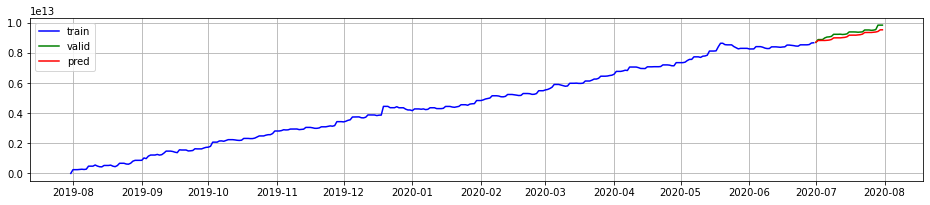


 Validation on Month 8:
	 Number of Train Data: 367
	 Number of Validation Data: 31
	 RMSLE: 0.013914535777915276


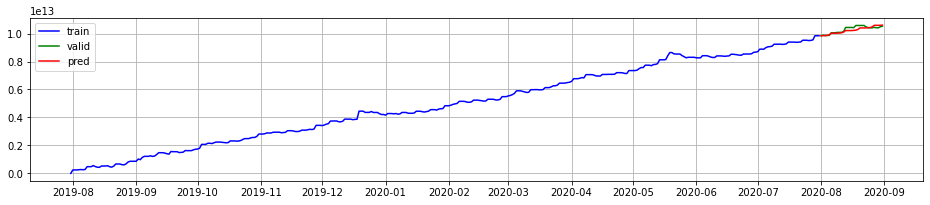


 Validation on Month 9:
	 Number of Train Data: 398
	 Number of Validation Data: 30
	 RMSLE: 0.006898816000630494


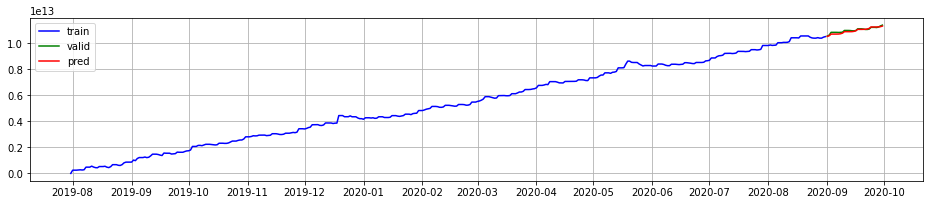


 Mean RMSLE: 0.01427908056470128
 Std RMSLE: 0.00618016369304165


In [6]:
SARIMA_CV(df, target='kas_kantor', order=(2,1,2), seasonal_order=(2,1,1,7))

## <p style='color:blue'> Kas echannel </p>


 Validation on Month 7:
	 Number of Train Data: 336
	 Number of Validation Data: 31
	 RMSLE: 0.26340816735507644


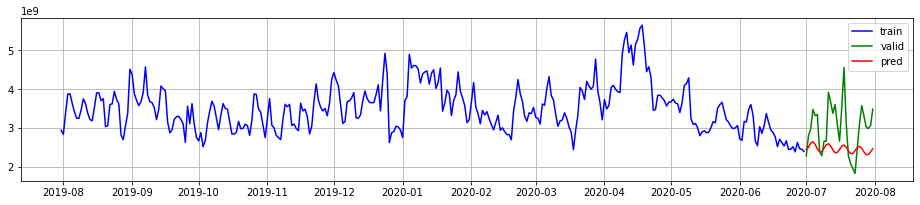


 Validation on Month 8:
	 Number of Train Data: 367
	 Number of Validation Data: 31
	 RMSLE: 0.3984332457911717


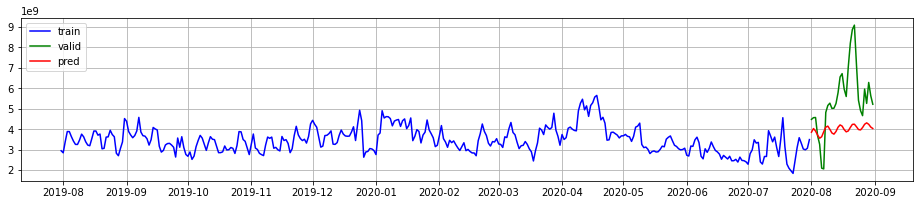


 Validation on Month 9:
	 Number of Train Data: 398
	 Number of Validation Data: 30
	 RMSLE: 0.09636212335264063


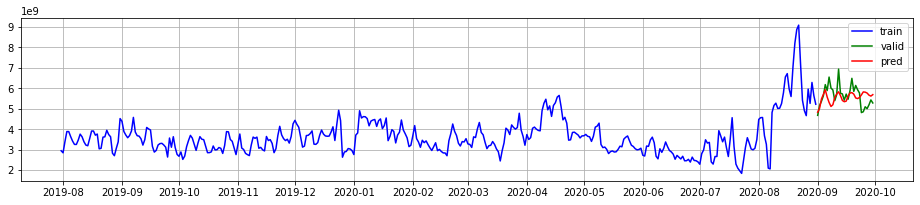


 Mean RMSLE: 0.2527345121662962
 Std RMSLE: 0.12355076133351084


In [7]:
SARIMA_CV(df, target='kas_echannel', order=(5,2,5), seasonal_order=(1,0,0,7))